In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from pandas.core.dtypes.common import is_numeric_dtype

In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'preprocessed_df.csv')
NEW_DATASET = os.path.join(DATA_FOLDER, 'final_dataset.csv')

In [3]:
df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

## Outliers using KNN

In [4]:
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler
import networkx as nx

n_neighbors = 20
normalized_df = (df[numerical_attr_list] - df[numerical_attr_list].min()) / (df[numerical_attr_list].max() - df[numerical_attr_list].min())
G = kneighbors_graph(normalized_df.values, n_neighbors=n_neighbors, mode='distance', p=np.inf)
G = nx.DiGraph(G)
dictator = nx.to_dict_of_dicts(G);

In [5]:
score = np.zeros(len(normalized_df))
for element in dictator.keys():
    mean_dist = 0
    for child in dictator[element].keys():
        mean_dist += dictator[element][child]["weight"] / n_neighbors
    score[element] = mean_dist

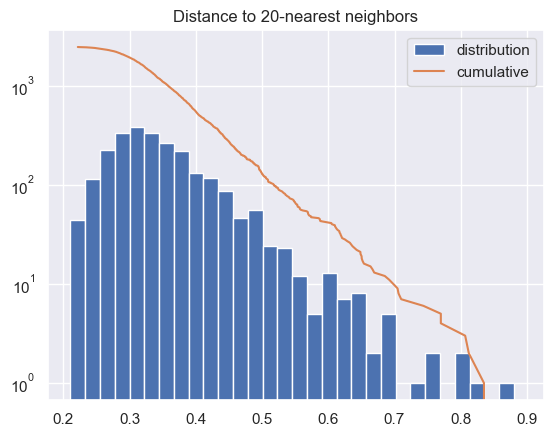

In [6]:
plt.hist(score, bins=30, align="left", label="distribution")
plt.plot(np.flip(np.sort(score)), np.linspace(0, len(df), len(df)), label="cumulative")
plt.yscale('log')
plt.title(f'Distance to {n_neighbors}-nearest neighbors')
plt.legend()
plt.show()

In [7]:
from sklearn.manifold import Isomap

reducer = Isomap(n_neighbors=n_neighbors, p=10)
embedding = reducer.fit_transform(normalized_df)
print(embedding.shape)

(2452, 2)


66


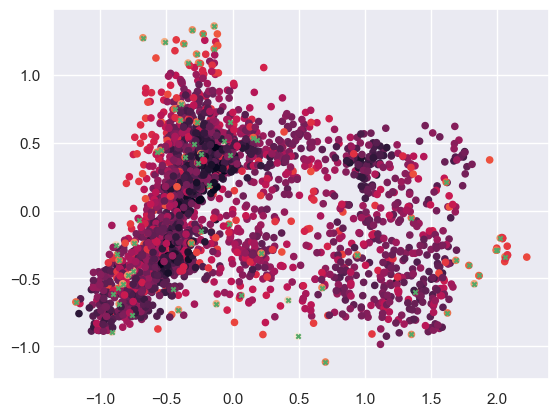

In [8]:
plt.scatter(*embedding.T, c=np.log10(score), s=20)
cutted = embedding[score > 0.55]
print(len(cutted))
plt.scatter(*cutted.T, marker="x", color="g", s=10)
plt.show()

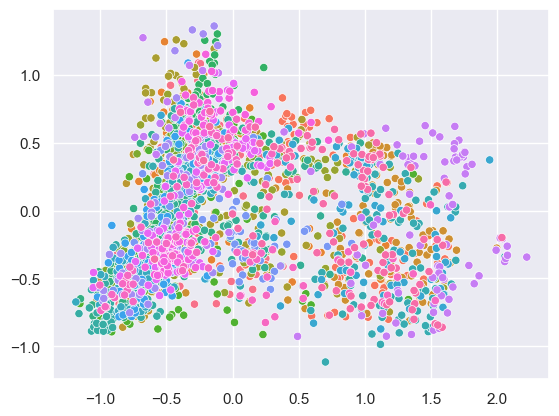

In [9]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df['actor'], legend=False)
plt.show()

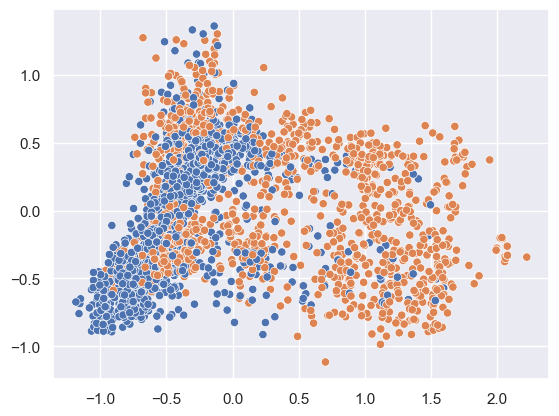

In [10]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df['sex'], legend=False)
plt.show()

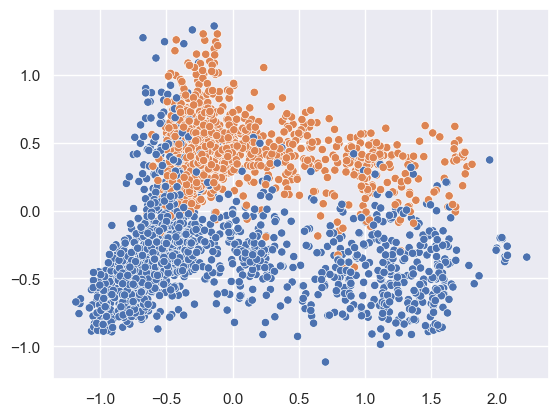

In [11]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df["vocal_channel"], legend=False)
plt.show()

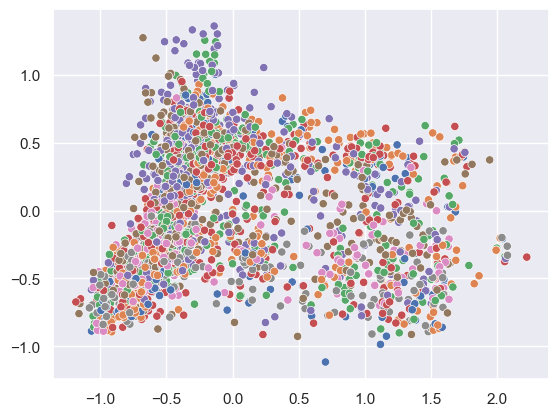

In [12]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df["emotion"], legend=False)
plt.show()

## Ensemble-based Approach: Isolation forest

In [13]:
df_isol_forest = df.copy()

### Division of the dataset by categories: sex

In [14]:
df_sex_m = df_isol_forest[df_isol_forest['sex'] == 'M']
df_sex_f = df_isol_forest[df_isol_forest['sex'] == 'F']

In [15]:
scaler = MinMaxScaler()

X_sex_f = scaler.fit_transform(df_sex_f[numerical_attr_list])
X_sex_m = scaler.fit_transform(df_sex_m[numerical_attr_list])

In [16]:
embedding_sex_f = reducer.fit_transform(X_sex_f)
embedding_sex_m = reducer.fit_transform(X_sex_m)

In [17]:
def get_score(X):
    G = kneighbors_graph(X, n_neighbors=n_neighbors, mode='distance', p=np.inf)
    G = nx.DiGraph(G)
    dictator = nx.to_dict_of_dicts(G)

    score = np.zeros(len(X))
    for element in dictator.keys():
        mean_dist = 0
        for child in dictator[element].keys():
            mean_dist += dictator[element][child]['weight'] / n_neighbors
        score[element] = mean_dist

    return score

In [18]:
score_sex_f = get_score(X_sex_f)
score_sex_m = get_score(X_sex_m)

### Isolation forest on F dataframe

In [19]:
from sklearn.ensemble import IsolationForest

isfo = IsolationForest(max_samples=200)
outliers = isfo.fit_predict(X_sex_f)

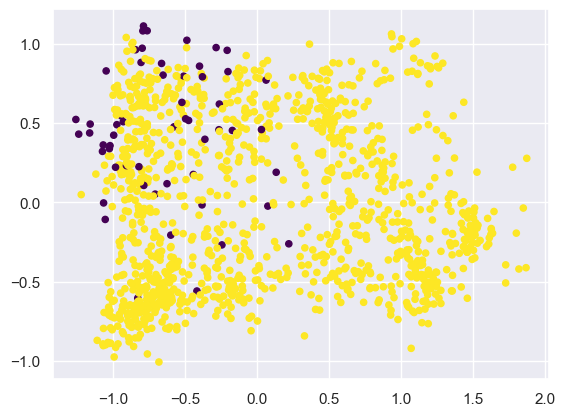

In [20]:
plt.scatter(*embedding_sex_f.T, c=outliers, s=20, cmap='viridis')
plt.show()

In [21]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  56, 1148]))

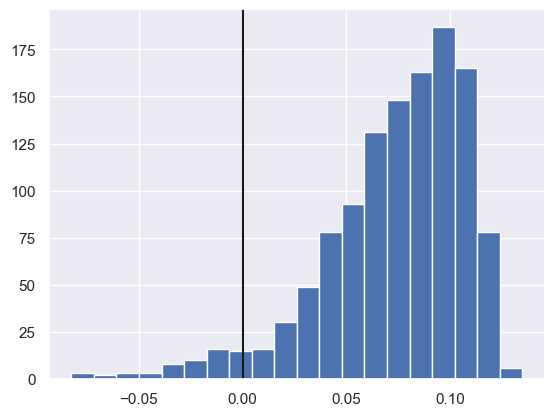

In [22]:
plt.hist(isfo.decision_function(X_sex_f), bins=20)
plt.axvline(np.min(isfo.decision_function(X_sex_f)[np.where(outliers == 1)]), c='k')
plt.show()

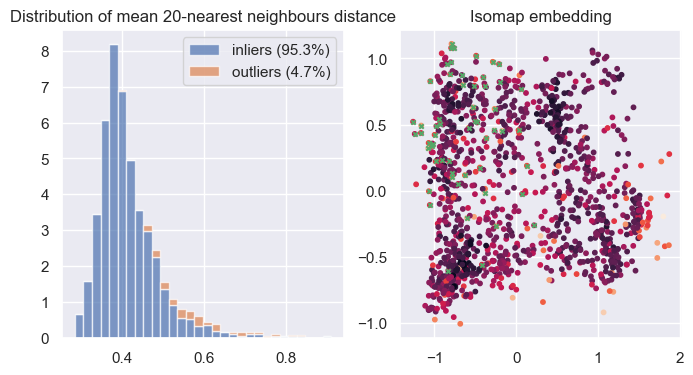

In [23]:
fig, (axhist, axscat) = plt.subplots(1, 2, figsize=(8,4))

axhist.set_title(f'Distribution of mean {n_neighbors}-nearest neighbours distance')
axscat.set_title('Isomap embedding')

axscat.scatter(*embedding_sex_f.T, c=np.log10(score_sex_f), s=10)
axscat.scatter(*embedding_sex_f[outliers == -1].T, marker='x', color='g', s=10)

labels = [
    f'inliers ({np.sum(outliers == 1) / len(df_sex_f) * 100:.1f}%)',
    f'outliers ({np.sum(outliers == -1) / len(df_sex_f) * 100:.1f}%)'
]

axhist.hist([score_sex_f[outliers == 1], score_sex_f[outliers == -1]], bins=30,
            label=labels, density=True, stacked=True, alpha=0.7)

axhist.legend();

In [24]:
df_sex_f = df_sex_f.loc[outliers == 1]
df_sex_f.shape

(1148, 250)

### Isolation forest on M dataframe

In [25]:
isfo = IsolationForest(max_samples=200)
outliers = isfo.fit_predict(X_sex_m)

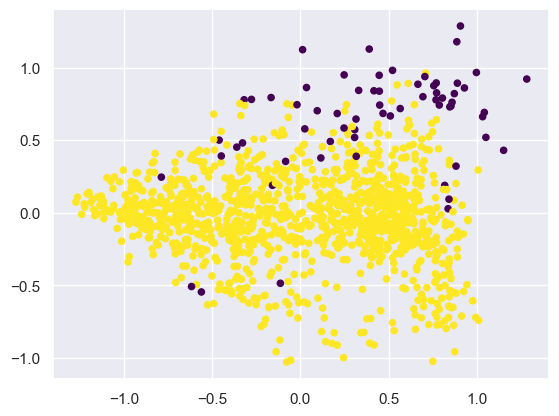

In [26]:
plt.scatter(*embedding_sex_m.T, c=outliers, s=20, cmap='viridis')
plt.show()

In [27]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  65, 1183]))

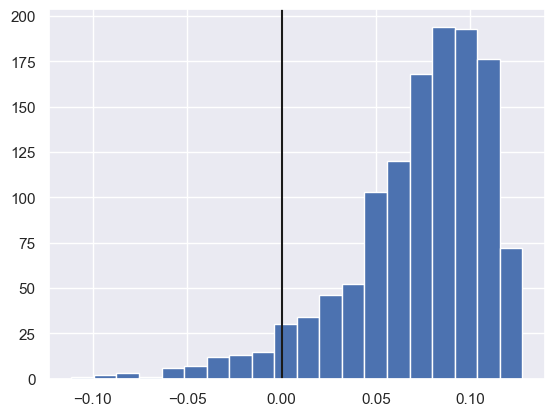

In [28]:
plt.hist(isfo.decision_function(X_sex_m), bins=20)
plt.axvline(np.min(isfo.decision_function(X_sex_m)[np.where(outliers == 1)]), c='k')
plt.show()

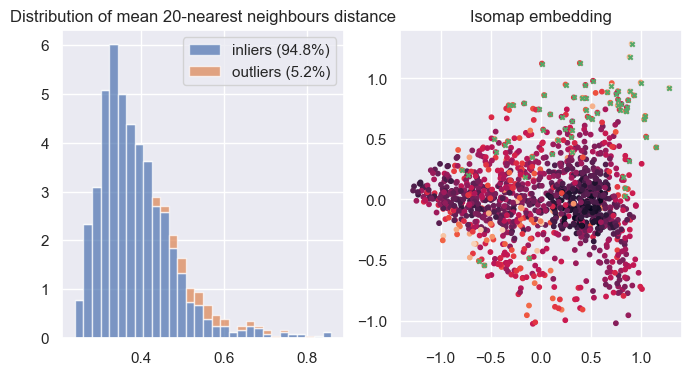

In [29]:
fig, (axhist, axscat) = plt.subplots(1, 2, figsize=(8,4))

axhist.set_title(f'Distribution of mean {n_neighbors}-nearest neighbours distance')
axscat.set_title('Isomap embedding')

axscat.scatter(*embedding_sex_m.T, c=np.log10(score_sex_m), s=10)
axscat.scatter(*embedding_sex_m[outliers == -1].T, marker='x', color='g', s=10)

labels = [
    f'inliers ({np.sum(outliers == 1) / len(df_sex_m) * 100:.1f}%)',
    f'outliers ({np.sum(outliers == -1) / len(df_sex_m) * 100:.1f}%)'
]

axhist.hist([score_sex_m[outliers == 1], score_sex_m[outliers == -1]], bins=30,
            label=labels, density=True, stacked=True, alpha=0.7)

axhist.legend();

In [30]:
df_sex_m = df_sex_m.loc[outliers == 1]
df_sex_m.shape

(1183, 250)

### Elimination of the outliers found

In [31]:
# creates an index list by combining the indexes of the two dataframes
new_indexes = pd.Index(df_sex_f.index.tolist() + df_sex_m.index.tolist())

# keep just the new indexes
df_isol_forest = df_isol_forest.loc[new_indexes]
df_isol_forest.shape

(2331, 250)

### Division of the dataset by categories: vocal_channel

In [32]:
df_speech = df_isol_forest[df_isol_forest['vocal_channel'] == 'speech']
df_song = df_isol_forest[df_isol_forest['vocal_channel'] == 'song']

In [33]:
scaler = MinMaxScaler()

X_speech = scaler.fit_transform(df_speech[numerical_attr_list])
X_song = scaler.fit_transform(df_song[numerical_attr_list])

In [34]:
embedding_speech = reducer.fit_transform(X_speech)
embedding_song = reducer.fit_transform(X_song)

In [35]:
score_speech = get_score(X_speech)
score_song = get_score(X_song)

### Isolation forest on speech dataframe

In [36]:
isfo = IsolationForest(max_samples=200)
outliers = isfo.fit_predict(X_speech)

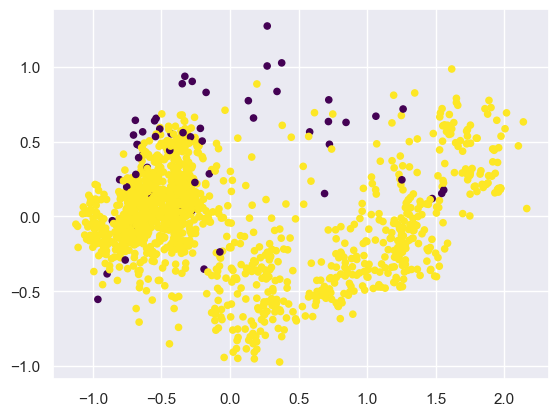

In [37]:
plt.scatter(*embedding_speech.T, c=outliers, s=20, cmap='viridis')
plt.show()

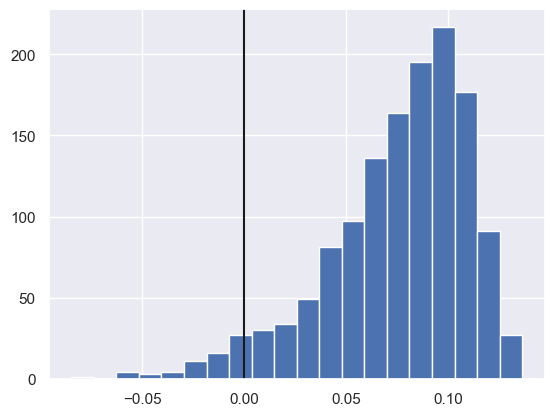

In [38]:
np.unique(outliers, return_counts=True)
plt.hist(isfo.decision_function(X_speech), bins=20)
plt.axvline(np.min(isfo.decision_function(X_speech)[np.where(outliers == 1)]), c='k')
plt.show()

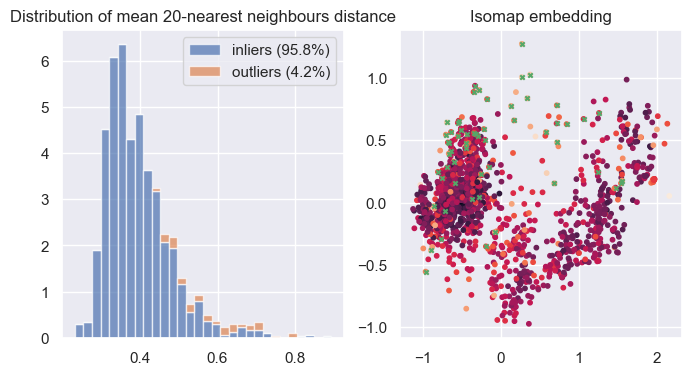

In [39]:
fig, (axhist, axscat) = plt.subplots(1, 2, figsize=(8, 4))

axhist.set_title(f'Distribution of mean {n_neighbors}-nearest neighbours distance')
axscat.set_title('Isomap embedding')

axscat.scatter(*embedding_speech.T, c=np.log10(score_speech), s=10)
axscat.scatter(*embedding_speech[outliers == -1].T, marker='x', color='g', s=10)

labels = [
    f'inliers ({np.sum(outliers == 1) / len(df_speech) * 100:.1f}%)',
    f'outliers ({np.sum(outliers == -1) / len(df_speech) * 100:.1f}%)'
]

axhist.hist([score_speech[outliers == 1], score_speech[outliers == -1]], bins=30,
            label=labels, density=True, stacked=True, alpha=0.7)

axhist.legend();

In [40]:
df_speech = df_speech.loc[outliers == 1]
df_speech.shape

(1307, 250)

### Isolation forest on song dataframe

In [41]:
isfo = IsolationForest(max_samples=200)
outliers = isfo.fit_predict(X_song)

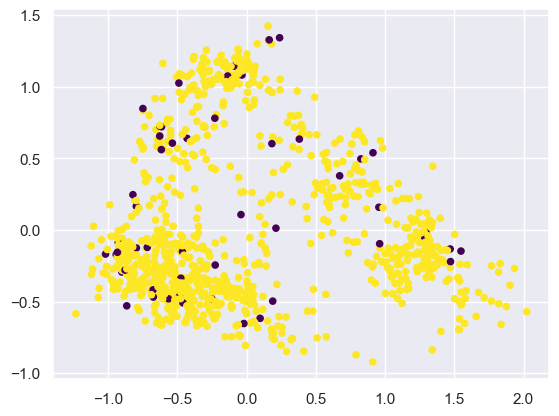

In [42]:
plt.scatter(*embedding_song.T, c=outliers, s=20, cmap='viridis')
plt.show()

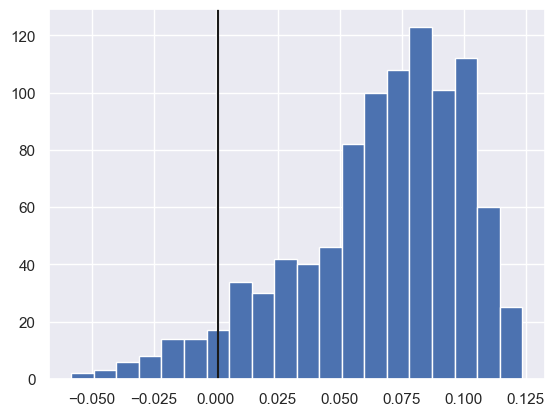

In [43]:
np.unique(outliers, return_counts=True)
plt.hist(isfo.decision_function(X_song), bins=20)
plt.axvline(np.min(isfo.decision_function(X_song)[np.where(outliers == 1)]), c='k')
plt.show()

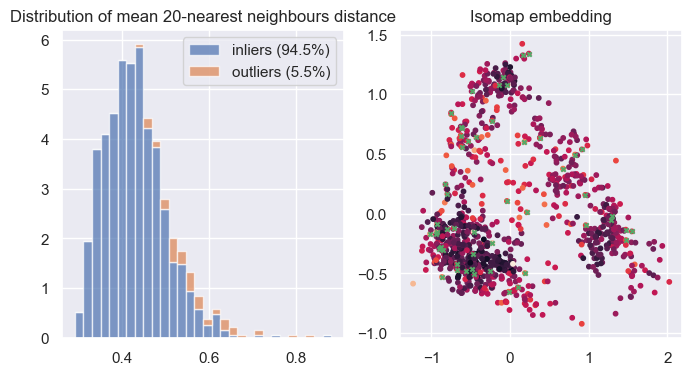

In [44]:
fig, (axhist, axscat) = plt.subplots(1, 2, figsize=(8, 4))

axhist.set_title(f'Distribution of mean {n_neighbors}-nearest neighbours distance')
axscat.set_title('Isomap embedding')

axscat.scatter(*embedding_song.T, c=np.log10(score_song), s=10)
axscat.scatter(*embedding_song[outliers == -1].T, marker='x', color='g', s=10)

labels = [
    f'inliers ({np.sum(outliers == 1) / len(df_song) * 100:.1f}%)',
    f'outliers ({np.sum(outliers == -1) / len(df_song) * 100:.1f}%)'
]

axhist.hist([score_song[outliers == 1], score_song[outliers == -1]], bins=30,
            label=labels, density=True, stacked=True, alpha=0.7)

axhist.legend();

In [45]:
df_song = df_song.loc[outliers == 1]
df_song.shape

(914, 250)

### Elimination of the outliers found

In [46]:
# creates an index list by combining the indexes of the two dataframes
new_indexes = pd.Index(df_speech.index.tolist() + df_song.index.tolist())

# keep just the new indexes
df_isol_forest = df_isol_forest.loc[new_indexes]
df_isol_forest.shape

(2221, 250)

## Visualize the new dataset

In [47]:
normalized_df = (df_isol_forest[numerical_attr_list] - df_isol_forest[numerical_attr_list].min()) / (df_isol_forest[numerical_attr_list].max() - df_isol_forest[numerical_attr_list].min())

In [48]:
reducer = Isomap(n_neighbors=n_neighbors, p=10)
embedding = reducer.fit_transform(normalized_df)

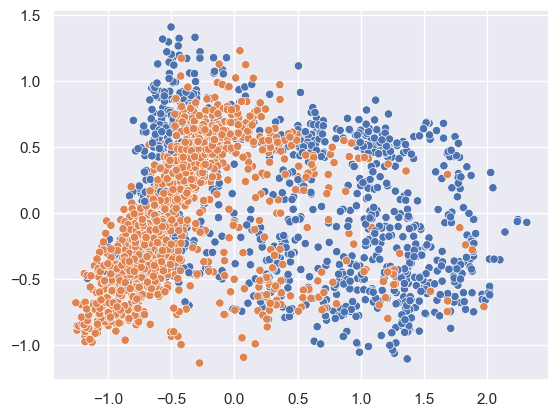

In [49]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df_isol_forest['sex'], legend=False)
plt.show()

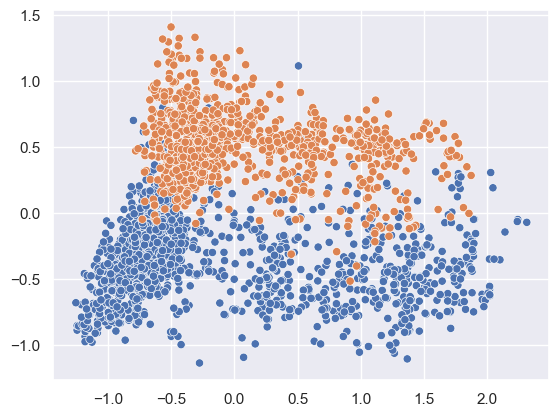

In [50]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df_isol_forest['vocal_channel'], legend=False)
plt.show()

In [51]:
df_isol_forest = df_isol_forest.reset_index(drop=True)

#### Isolation forest problem: It deleted more than 200 data points, and there's no way to decide which were more outliers than others

## LOF

In [52]:
df_sex_m = df[df['sex'] == 'M']
df_sex_f = df[df['sex'] == 'F']

df_sex_m = df_sex_m[numerical_attr_list]
df_sex_f = df_sex_f[numerical_attr_list]

In [53]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=10)
outliers = clf.fit_predict(df_sex_m)

In [54]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  17, 1231]))

In [55]:
df_sex_m['outlier_score'] = clf.negative_outlier_factor_

is_outlier = np.where(outliers == 1, False, True)
df_sex_m['is_outlier'] = is_outlier

In [56]:
clf = LocalOutlierFactor(n_neighbors=10)
outliers = clf.fit_predict(df_sex_f)

In [57]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  20, 1184]))

In [58]:
df_sex_f['outlier_score'] = clf.negative_outlier_factor_

is_outlier = np.where(outliers == 1, False, True)
df_sex_f['is_outlier'] = is_outlier

In [59]:
df['outlier_score_sex'] = df_sex_f['outlier_score'].combine_first(df_sex_m['outlier_score'])
df['is_outlier_sex'] = df_sex_f['is_outlier'].combine_first(df_sex_m['is_outlier'])
df[['outlier_score_sex', 'is_outlier_sex']]

,outlier_score_sex,is_outlier_sex
0,-1.041794,False
1,-0.966584,False
2,-0.986116,False
3,-1.041954,False
4,-1.004026,False
...,...,...
2447,-1.045691,False
2448,-1.114400,False
2449,-1.062986,False
2450,-1.113518,False


In [60]:
df_speech = df[df['vocal_channel'] == 'speech']
df_song = df[df['vocal_channel'] == 'song']

df_speech = df_speech[numerical_attr_list]
df_song = df_song[numerical_attr_list]

In [61]:
clf = LocalOutlierFactor(n_neighbors=10)
outliers = clf.fit_predict(df_speech)

In [62]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  24, 1416]))

In [63]:
df_speech['outlier_score'] = clf.negative_outlier_factor_

is_outlier = np.where(outliers == 1, False, True)
df_speech['is_outlier'] = is_outlier

In [64]:
clf = LocalOutlierFactor(n_neighbors=10)
outliers = clf.fit_predict(df_song)

In [65]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  12, 1000]))

In [66]:
df_song['outlier_score'] = clf.negative_outlier_factor_

is_outlier = np.where(outliers == 1, False, True)
df_song['is_outlier'] = is_outlier

In [67]:
df['outlier_score_vc'] = df_song['outlier_score'].combine_first(df_speech['outlier_score'])
df['is_outlier_vc'] = df_song['is_outlier'].combine_first(df_speech['is_outlier'])
df[['outlier_score_vc', 'is_outlier_vc']]

,outlier_score_vc,is_outlier_vc
0,-0.998850,False
1,-0.970485,False
2,-0.976422,False
3,-0.977693,False
4,-0.985296,False
...,...,...
2447,-1.003746,False
2448,-1.002312,False
2449,-1.079676,False
2450,-1.168761,False


#### now that all outlier scores have been calculated, it is possible to select the top 1%

In [68]:
df_outliers = df.loc[(df['is_outlier_sex'] == True) | (df['is_outlier_vc'] == True)]

In [69]:
scores = df_outliers['outlier_score_sex'] + df_outliers['outlier_score_vc']
scores

40     -2.957023
46     -2.787832
168    -3.171318
223    -3.085421
292    -2.739169
352    -3.614107
382    -3.579011
425    -2.991441
527    -2.633372
528    -2.812352
589    -3.385376
688    -2.756811
708    -2.800389
709    -2.677369
832    -3.210394
843    -3.056893
901    -3.014006
903    -3.147779
927    -3.220333
1194   -2.991098
1204   -2.966194
1241   -2.680327
1387   -3.110903
1420   -3.152139
1421   -3.288282
1422   -2.918016
1546   -2.991425
1702   -3.555363
1815   -3.138233
1816   -3.180376
1818   -3.610952
1819   -3.574984
1839   -2.582098
1840   -3.184684
1851   -3.285651
1861   -2.952793
1871   -3.044992
1914   -4.011975
1948   -2.981978
1968   -3.312819
1969   -3.592681
1979   -3.439580
1981   -3.300228
1982   -5.246693
2000   -3.545308
2010   -2.846725
2046   -2.906270
2210   -3.231426
2268   -2.762965
2271   -4.306768
2375   -3.046881
2383   -3.208409
2392   -3.863777
dtype: float64

In [70]:
# find top 1% outliers
one_percent = int(df.shape[0] / 100)
top1pct_outliers_lof = scores.nsmallest(one_percent)
top1pct_outliers_lof

1982   -5.246693
2271   -4.306768
1914   -4.011975
2392   -3.863777
352    -3.614107
1818   -3.610952
1969   -3.592681
382    -3.579011
1819   -3.574984
1702   -3.555363
2000   -3.545308
1979   -3.439580
589    -3.385376
1968   -3.312819
1981   -3.300228
1421   -3.288282
1851   -3.285651
2210   -3.231426
927    -3.220333
832    -3.210394
2383   -3.208409
1840   -3.184684
1816   -3.180376
168    -3.171318
dtype: float64